In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
print(torch.cuda.is_available())

True


## Prepare data

In [23]:
df = pd.read_csv('merge_train.csv',parse_dates=['date'])
df.columns

Index(['date', 'Demand', 'Price', 'Region', 'Forecast_Demand_0.5 hour future',
       'Forecast_Demand_1 hour future', 'Forecast_Demand_1.5 hours future',
       'Forecast_Demand_2 hours future', 'Forecast_Demand_2.5 hours future',
       'Forecast_Demand_3 hours future', 'Forecast_Demand_3.5 hours future',
       'Forecast_Demand_4 hours future', 'Forecast_Demand_4.5 hours future',
       'Forecast_Demand_5 hours future', 'Forecast_Demand_5.5 hours future',
       'Forecast_Demand_6 hours future', 'Forecast_Demand_6.5 hours future',
       'Forecast_Demand_7 hours future', 'Forecast_Demand_7.5 hours future',
       'Forecast_Demand_8 hours future', 'Forecast_Demand_8.5 hours future',
       'Forecast_Demand_9 hours future', 'Forecast_Demand_9.5 hours future',
       'Forecast_Roof_0.5 hour future', 'Forecast_Roof_1 hour future',
       'Forecast_Roof_1.5 hours future', 'Forecast_Roof_2 hours future',
       'Forecast_Roof_2.5 hours future', 'Forecast_Roof_3 hours future',
       'Fore

In [24]:
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekdays'] = df['date'].dt.dayofweek  # 1 for weekend, 0 for weekday
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df.head()

,date,Demand,Price,Region,Forecast_Demand_0.5 hour future,Forecast_Demand_1 hour future,Forecast_Demand_1.5 hours future,Forecast_Demand_2 hours future,Forecast_Demand_2.5 hours future,Forecast_Demand_3 hours future,...,Forecast_Roof_9.5 hours future,Actual_Demand_OPERATIONAL_DEMAND,Actual_Roof_OPOWER,Actual_Roof_LASTCHANGED,Adjusted_Actual_Roof_OPOWER,month,day,weekdays,hour,minute
0,2023-07-23 00:00:00,5988.16,75.93,QLD1,5874.0,5718.0,5608.0,5517.0,5450.0,5407.0,...,1930.152,6057.0,0.0,2023-07-23 00:19:15,0.0,7,23,6,0,0
1,2023-07-23 00:05:00,6002.58,151.76,QLD1,5874.0,5718.0,5608.0,5517.0,5450.0,5407.0,...,1930.152,6057.0,0.0,2023-07-23 00:19:15,0.0,7,23,6,0,5
2,2023-07-23 00:10:00,5918.29,95.11,QLD1,5874.0,5718.0,5608.0,5517.0,5450.0,5407.0,...,1930.152,6057.0,0.0,2023-07-23 00:19:15,0.0,7,23,6,0,10
3,2023-07-23 00:15:00,5930.99,95.74,QLD1,5874.0,5718.0,5608.0,5517.0,5450.0,5407.0,...,1930.152,6057.0,0.0,2023-07-23 00:19:15,0.0,7,23,6,0,15
4,2023-07-23 00:20:00,5836.53,94.39,QLD1,5874.0,5718.0,5608.0,5517.0,5450.0,5407.0,...,1930.152,6057.0,0.0,2023-07-23 00:19:15,0.0,7,23,6,0,20


In [26]:
df['EMA_4h'] = df['Price'].ewm(span=48, adjust=False).mean()

# 計算1天EMA（288個數據點）
df['EMA_1d'] = df['Price'].ewm(span=288, adjust=False).mean()

df = df.dropna()

In [30]:
Features = ['Demand', 'Price', 'Forecast_Demand_0.5 hour future',
       'Forecast_Demand_1 hour future', 'Forecast_Demand_1.5 hours future',
       'Forecast_Demand_2 hours future', 'Forecast_Demand_2.5 hours future',
       'Forecast_Demand_3 hours future', 'Forecast_Demand_3.5 hours future',
       'Forecast_Demand_4 hours future', 'Forecast_Demand_4.5 hours future',
       'Forecast_Demand_5 hours future', 'Forecast_Demand_5.5 hours future',
       'Forecast_Demand_6 hours future', 'Forecast_Demand_6.5 hours future',
       'Forecast_Demand_7 hours future', 'Forecast_Demand_7.5 hours future',
       'Forecast_Demand_8 hours future', 'Forecast_Demand_8.5 hours future',
       'Forecast_Demand_9 hours future', 'Forecast_Demand_9.5 hours future',
       'Forecast_Roof_0.5 hour future', 'Forecast_Roof_1 hour future',
       'Forecast_Roof_1.5 hours future', 'Forecast_Roof_2 hours future',
       'Forecast_Roof_2.5 hours future', 'Forecast_Roof_3 hours future',
       'Forecast_Roof_3.5 hours future', 'Forecast_Roof_4 hours future',
       'Forecast_Roof_4.5 hours future', 'Forecast_Roof_5 hours future',
       'Forecast_Roof_5.5 hours future', 'Forecast_Roof_6 hours future',
       'Forecast_Roof_6.5 hours future', 'Forecast_Roof_7 hours future',
       'Forecast_Roof_7.5 hours future', 'Forecast_Roof_8 hours future',
       'Forecast_Roof_8.5 hours future', 'Forecast_Roof_9 hours future',
       'Forecast_Roof_9.5 hours future', 'Actual_Demand_OPERATIONAL_DEMAND',
       'Adjusted_Actual_Roof_OPOWER','EMA_4h', 'EMA_1d']

In [31]:
split_date = "2024-06-01 00:00:00"
train_df = df[df['date'] < split_date]
test_df = df[df['date'] >= split_date]

X_train = train_df[Features]
y_train = train_df["Price"]
X_test = test_df[Features].reset_index(drop=True)
y_test = test_df["Price"].reset_index(drop=True)

In [32]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((90432, 44), (90432,), (18421, 44), (18421,))

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 2*hidden_size)
        self.fc2 = nn.Linear(2*hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size).to(device)
        # c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x)
        
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        out=  F.elu(self.fc3(out)) 
        return out

def prepare_data(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        
        X_seq.append(X[i:i+seq_length])
        
        y_seq.append(y[i+seq_length])
        
    return np.array(X_seq), np.array(y_seq)

In [34]:


seq_length = 144

X_train_seq, y_train_seq = prepare_data(X_train, y_train, seq_length)
X_test_seq, y_test_seq = prepare_data(X_test, y_test, seq_length)

#GPU
print(device)
X_train_tensor = torch.FloatTensor(X_train_seq)
y_train_tensor = torch.FloatTensor(y_train_seq)
X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test_seq)



cuda


In [40]:
#Initialize model
from torch.optim.lr_scheduler import StepLR
input_size = X_train.shape[1]  #Feature numbers
hidden_size = 128
num_layers = 2
output_size = 1
batch_size = 32
num_epochs = 50
learning_rate = 0.001
step_size = 5
gamma = 0.1

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

#Train model
train_losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    # scheduler.step()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [10/50], Loss: 142983.5889
Epoch [20/50], Loss: 139030.9349
Epoch [30/50], Loss: 138969.5225


KeyboardInterrupt: 

In [14]:
# PATH = "model.pt"

# # Save
# torch.save(model.state_dict(), PATH)

# # Load
# cpu_device = torch.device('cpu')
# test_model = LSTMModel(input_size, hidden_size, num_layers, output_size)
# test_model.load_state_dict(torch.load(PATH, map_location=cpu_device, weights_only=True))

<All keys matched successfully>

Mean Squared Error: 73468.0938
Mean Absolute Error: 87.7359
Root Mean Squared Error: 271.0500


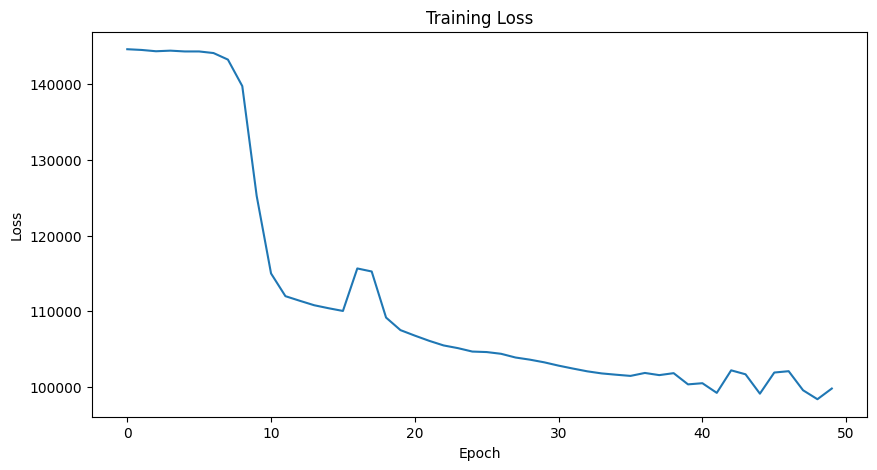

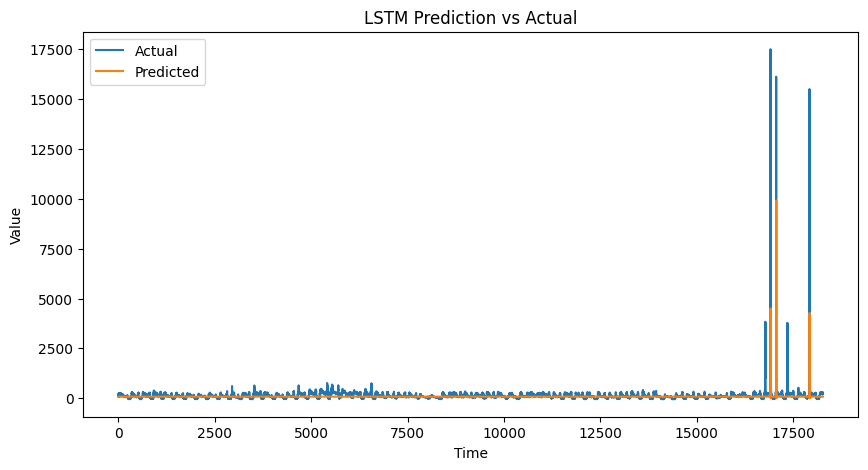

In [36]:
#Evaluate model
model.to("cpu")
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()
    y_true = y_test_tensor.cpu().numpy()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")


plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('LSTM Prediction vs Actual')
# plt.ylim([-100, 10000])
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [38]:
for i in y_pred:
    
    print(i)

[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]
[77.67078]